<h1> Robot Navigation Project </h1>

In [23]:
## referencies:
# http://vision.deis.unibo.it/~smatt/Papers/VI2002/VI2002.pdf

<h3> Libraries and Global Variables </h3>

In [24]:
f = 567.2 # focal length in pixel
b = 92.226 # base line in mm
cb_w = 125 # chessboard total width in  mm
cb_h = 178 # chessboard total height in mm
pattern_size = (6, 8) # number of inner corner, (columns, rows) of chessboard

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<h3> Extracting image frames from video </h3>

In [26]:
roboL = cv2.VideoCapture('./robotL.avi')
roboL_frames = []

while roboL.isOpened():
    ret, frame = roboL.read()
    if not ret:
        break
    roboL_frames = roboL_frames + [frame]

In [27]:
roboR = cv2.VideoCapture('./robotR.avi')
roboR_frames = []

while roboR.isOpened():
    ret, frame = roboR.read()
    if not ret:
        break
    roboR_frames = roboR_frames + [frame]

In [28]:
print("No. of frames for left camera : ", len(roboL_frames))
print("No of frames for right camera : ", len(roboR_frames))

No. of frames for left camera :  389
No of frames for right camera :  389


In [29]:
if len(roboL_frames) != len(roboR_frames):
    print('Error number of frames dos not match')
number_of_frames = len(roboL_frames)
print(number_of_frames)

389


In [30]:
roboL_frames[10].shape

(480, 640, 3)

<h3> Image Processing & Histogram Analysis on single image </h3>

In [31]:
img = roboL_frames[100]

In [32]:
def plot_histogram(image, title, mask=None):
	# split the image into its respective channels, then initialize
	# the tuple of channel names along with our figure for plotting
	chans = cv2.split(image)
	colors = ("b", "g", "r")
	plt.figure()
	plt.title(title)
	plt.xlabel("Bins")
	plt.ylabel("# of Pixels")
	# loop over the image channels
	for (chan, color) in zip(chans, colors):
		# create a histogram for the current channel and plot it
		hist = cv2.calcHist([chan], [0], mask, [256], [0, 256])
		plt.plot(hist, color=color)
		plt.xlim([0, 256])

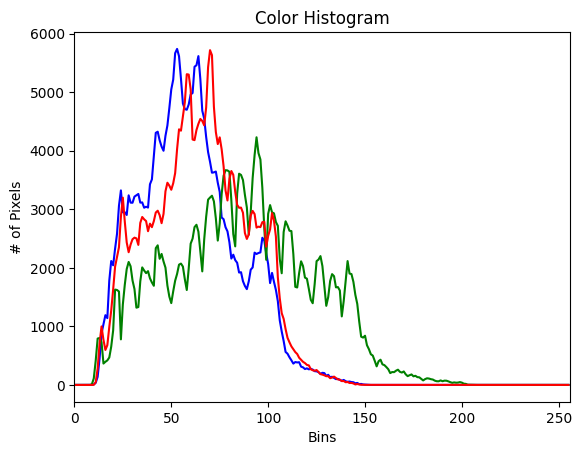

In [33]:
plot_histogram(img, 'Color Histogram')

In [34]:
img_gray1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray2 = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

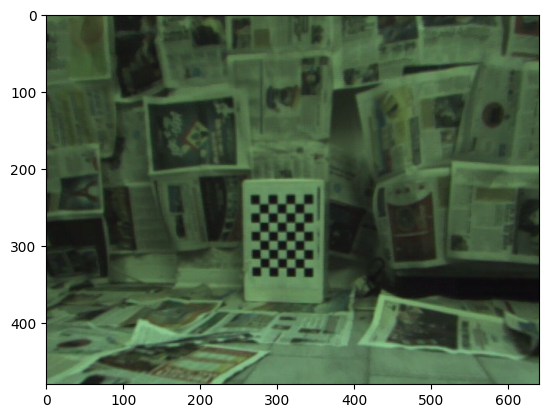

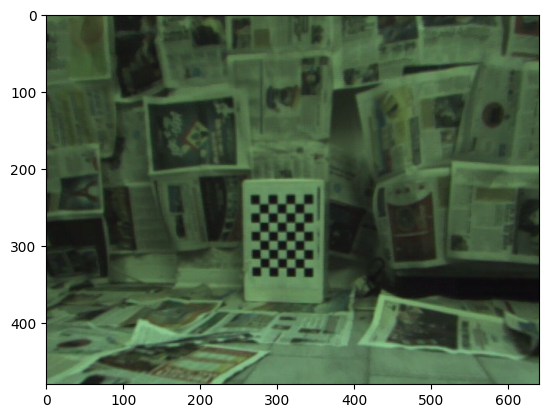

In [35]:
img_x = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_x)
plt.show()
img_x = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img_x)
plt.show()

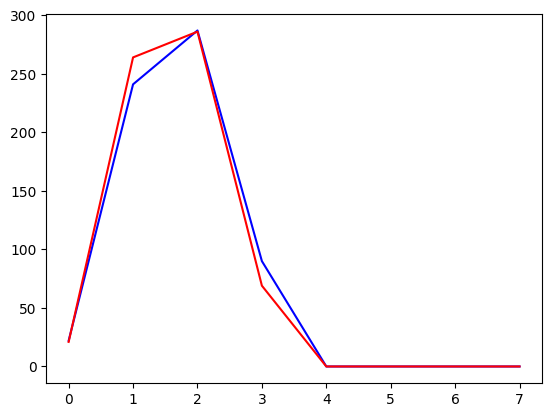

In [36]:
hist1 = cv2.calcHist(img_gray1, [0], None, [8], [0, 256])
hist2 = cv2.calcHist(img_gray2, [0], None, [8], [0, 256])
plt.plot(hist1, 'b')
plt.plot(hist2, 'r')
plt.show()

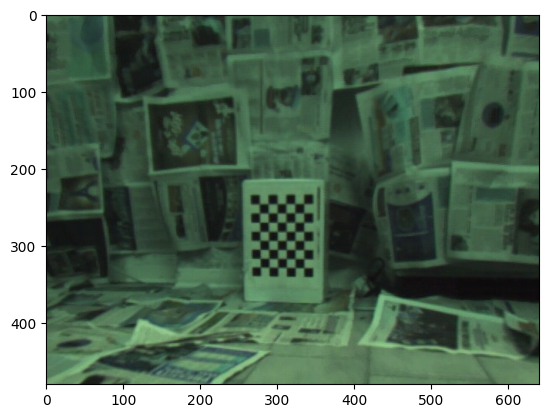

In [37]:
plt.imshow(img)
plt.show()

<h3> Converting to NumPy Array </h3>


In [38]:
np_L = np.array(roboL_frames)
np_R = np.array(roboR_frames)

<h2> Cropping </h2>

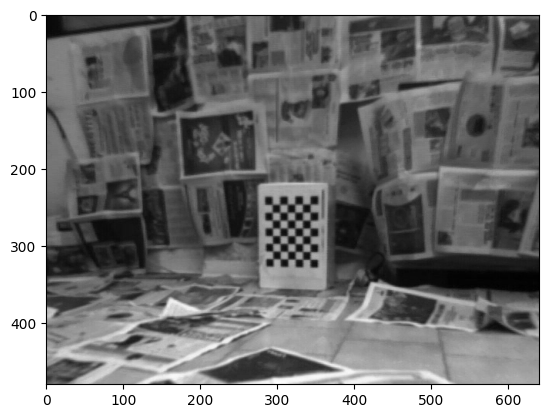

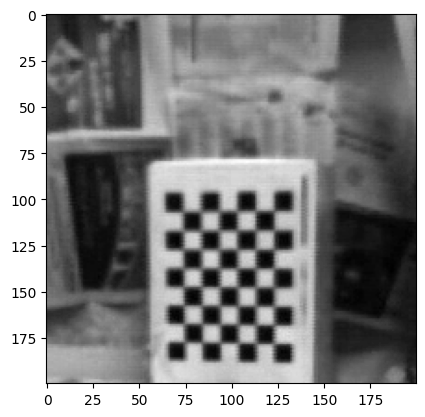

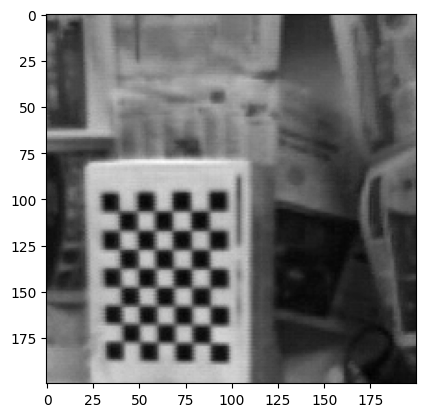

uint8
uint8


(389, 480, 640)

In [91]:
np_L_gray = np.array([cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY) for frame in np_L])
np_R_gray = np.array([cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY) for frame in np_R])
framenumber = 200

Box_size=200
sq_area_side=int(Box_size/2)
offset = 0
frame_height = np_L_gray.shape[1]
frame_width = np_L_gray.shape[2]

np_L_cropped=np_L_gray[framenumber,int(frame_height/2)-sq_area_side:int(frame_height/2)+sq_area_side,int(frame_width/2)-sq_area_side:int(frame_width/2)+sq_area_side]
np_R_cropped=np_R_gray[framenumber,int(frame_height/2)-sq_area_side:int(frame_height/2)+sq_area_side,int(frame_width/2)-sq_area_side-offset:int(frame_width/2)+sq_area_side-offset]

# Display the images
plt.imshow(np_L_gray[framenumber], cmap='gray')
plt.show()
# plt.imshow(np_R_gray[framenumber], cmap='gray')
# plt.show()
plt.imshow(np_L_cropped, cmap='gray')
plt.show()
plt.imshow(np_R_cropped, cmap='gray')
plt.show()

print(np_L_cropped.dtype)
print(np_R_cropped.dtype)

np_L_gray.shape

# Disparity map

Mean positive disparity: nan


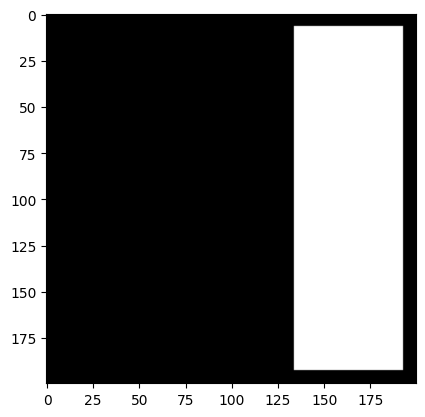

In [109]:
stereo = cv2.StereoBM_create(numDisparities=128, blockSize=15)

# Change the method used by StereoBM (for example, change to SSD)
#stereo.setPreFilterType(cv2.STEREO_BM_NARROW_PRESET)
 #   cv2.STEREO_BM_BASIC_PRESET: Normalized Sum of Absolute Differences (SAD)
  #  cv2.STEREO_BM_FISH_EYE_PRESET: Fish-eye distortion tolerant SAD
   # cv2.STEREO_BM_NARROW_PRESET: Normalized Sum of Squared Differences (SSD)
    #cv2.STEREO_BM_XSOBEL: Cross-based matching algorithm using the Sobel operator
    # cv2.STEREO_BM_LS: Locally supported matching algorithm (LS)

disparity = stereo.compute(np_L_cropped,np_L_cropped)

disparity=disparity/16
plt.imshow(disparity,'gray')

# Filter out positive disparity values
positive_disparities = disparity[disparity > 0]

# Calculate mean of positive disparities
mean_disparity = np.mean(positive_disparities)

print("Mean positive disparity:", mean_disparity)

In [107]:
d_main = mean_disparity + offset
z_mm = f*b/d_main
z_mm

1628.397979158672

Mean positive disparity: 32.123957330766764
Distance in mm: 1623.0241091352752


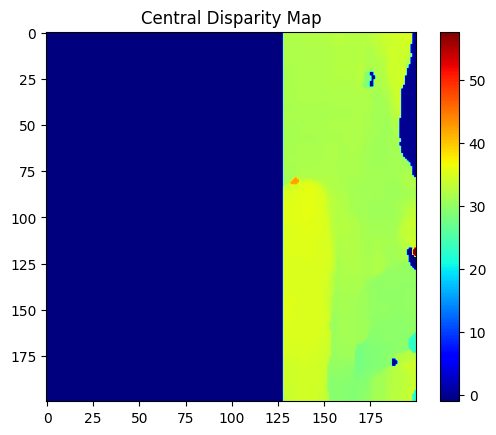

In [108]:
minDisparity=0                  # Minimum possible disparity value
numDisparities=128                # Range of disparity (maxDisparity - minDisparity)
blockSize=21                     # Size of the window used for matching (odd values only)
P1=0                             # Penalty for the first pixel disparity difference
P2=0                             # Penalty for the second pixel disparity difference
disp12MaxDiff=0               # Maximum allowed difference in the left-right disparity check
preFilterCap=0                   # Maximum allowed difference in the left-right disparity check
uniquenessRatio=0              # Margin in percentage by which the best (minimum) computed cost function value should "win"
speckleWindowSize=0              # Maximum size of smooth disparity regions to consider them as a speckle
speckleRange=0                   # Maximum disparity variation within each connected component
mode = 0                         # Set it to StereoSGBM::MODE_HH to run the full-scale two-pass dynamic programming algorithm.

stereo = cv2.StereoSGBM_create(minDisparity,numDisparities,blockSize,P1,P2,disp12MaxDiff,preFilterCap,uniquenessRatio,speckleWindowSize,speckleRange,mode)
disparity = stereo.compute(np_L_cropped,np_R_cropped)
#disparity_map = cv2.normalize(disparity_map, disparity_map, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

disparity=disparity/16

# Filter out positive disparity values
positive_disparities = disparity[disparity > 0]

# Calculate mean of positive disparities
d_main = np.mean(positive_disparities)

print("Mean positive disparity:", mean_disparity)

z_mm = f*b/d_main
print("Distance in mm:", z_mm)

plt.imshow(disparity, cmap='jet')
plt.colorbar()
plt.title(f'Central Disparity Map')
plt.show()

<h3> Detecting Chessboard Pattern (Single Image)</h3>

In [32]:
pattern_size = (6, 8) # number of inner corner, (columns, rows) for OpenCV

In [33]:
found, corners = cv2.findChessboardCorners(img_gray1, pattern_size)
print("Found: " , found)
print("2D image coordinate of corners: ", corners)

Found:  True
2D image coordinate of corners:  [[[276.77643 247.1833 ]]

 [[288.34442 246.24152]]

 [[300.23627 246.1392 ]]

 [[311.06436 245.73996]]

 [[322.5864  246.46198]]

 [[334.53333 246.01067]]

 [[277.4241  258.45352]]

 [[288.36777 258.61804]]

 [[300.2728  258.44012]]

 [[311.5822  257.81454]]

 [[322.94647 258.50693]]

 [[334.7256  258.35684]]

 [[277.58463 270.1731 ]]

 [[288.76236 270.2757 ]]

 [[300.45737 270.48715]]

 [[311.70044 270.52765]]

 [[322.75998 270.51468]]

 [[334.67145 270.61746]]

 [[277.97617 282.36536]]

 [[288.80505 282.58575]]

 [[300.47955 281.97552]]

 [[311.71667 282.5574 ]]

 [[322.92142 282.3305 ]]

 [[334.5188  282.42157]]

 [[278.094   293.49518]]

 [[289.37146 293.67734]]

 [[300.1503  293.78873]]

 [[311.84204 293.9367 ]]

 [[323.49518 294.0064 ]]

 [[334.5832  294.02924]]

 [[278.02307 305.50446]]

 [[289.44888 305.51715]]

 [[300.4255  305.6942 ]]

 [[312.06424 305.9823 ]]

 [[323.64902 306.12842]]

 [[334.71533 306.0364 ]]

 [[277.6871  317.4

In [34]:
corners.shape

(48, 1, 2)

In [35]:
# Do cornerSubPix only if chessboard found is True
if found:
    #Refining corner position to subpixel iteratively until criteria max_count=30 or criteria_eps_error=1 is sutisfied
    term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 1)
    #Image Corners 
    cv2.cornerSubPix(img_gray1, corners, (5, 5), (-1, -1), term)
    print("Found")
else:
    print("Not Found")

Found


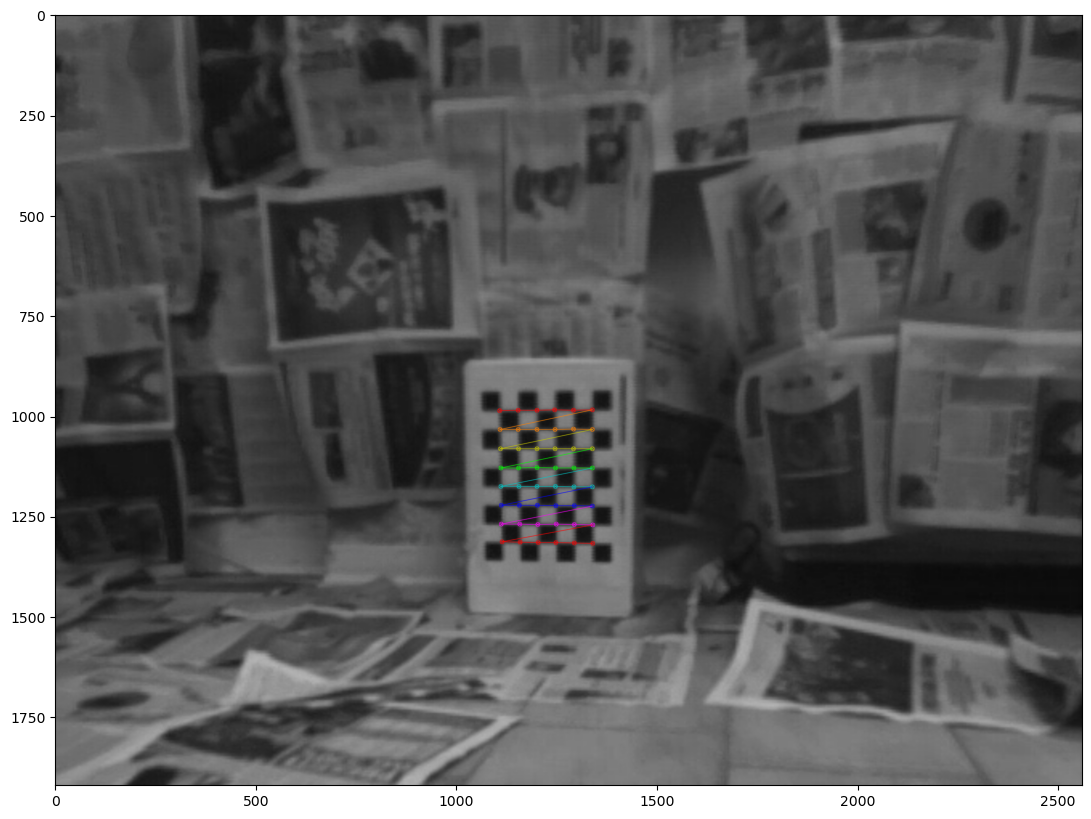

In [36]:
vis = cv2.cvtColor(img_gray1, cv2.COLOR_GRAY2BGR)
vis = cv2.resize(vis,None,fx=4, fy=4)
cv2.drawChessboardCorners(vis, pattern_size, corners*4, found)
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.show()

# Computing distance of the camera from the chessboard referred to specific frame 

In [37]:
imgL = roboL_frames[100]
imgR = roboR_frames[100]
imgL_gray = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
imgR_gray = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

In [38]:
pattern_size = (6, 8) # number of inner corner, (columns, rows) for OpenCV
foundL, cornersL = cv2.findChessboardCorners(imgL_gray, pattern_size)
foundR, cornersR = cv2.findChessboardCorners(imgR_gray, pattern_size)

# Do cornerSubPix only if chessboard found is True
if foundL and foundR:
    #Refining corner position to subpixel iteratively until criteria max_count=30 or criteria_eps_error=1 is sutisfied
    term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 1)
    #Image Corners 
    cv2.cornerSubPix(imgL_gray, cornersL, (5, 5), (-1, -1), term)
    cv2.cornerSubPix(imgR_gray, cornersR, (5, 5), (-1, -1), term)

print("Found: " , foundL)
print("Found: " , foundR)
#print("2D image coordinate of corners: ", cornersL)
#print("2D image coordinate of corners: ", cornersR)

Found:  True
Found:  True


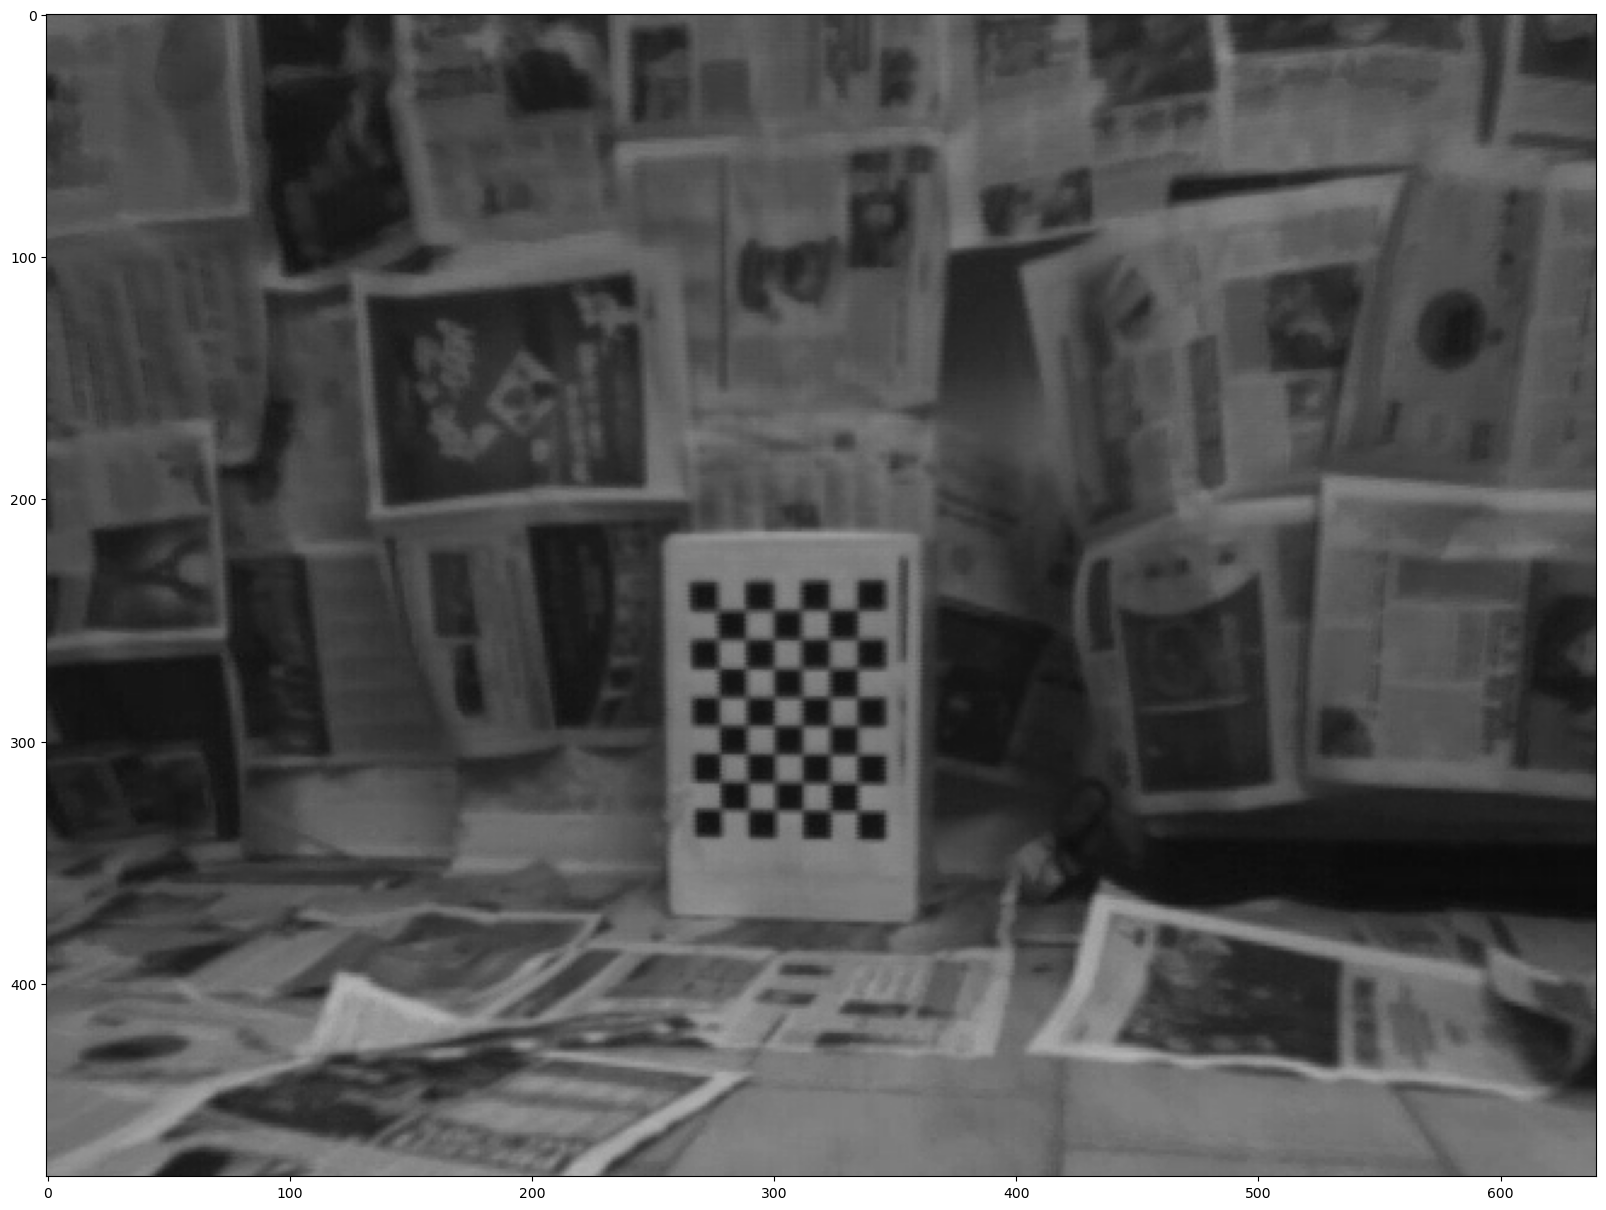

In [39]:
# To check correctness of coordinates
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

fig = plt.figure(figsize=(20,30))

def onclick(event):
    ix, iy = event.xdata, event.ydata
    print("Coordinate clicked pixel (row,column): [{},{}]".format(int(round(ix)), int(round(iy))))

cid = fig.canvas.mpl_connect('button_press_event', onclick)

imgplot = plt.imshow(cv2.cvtColor(imgL_gray, cv2.COLOR_BGR2RGB))
plt.show()

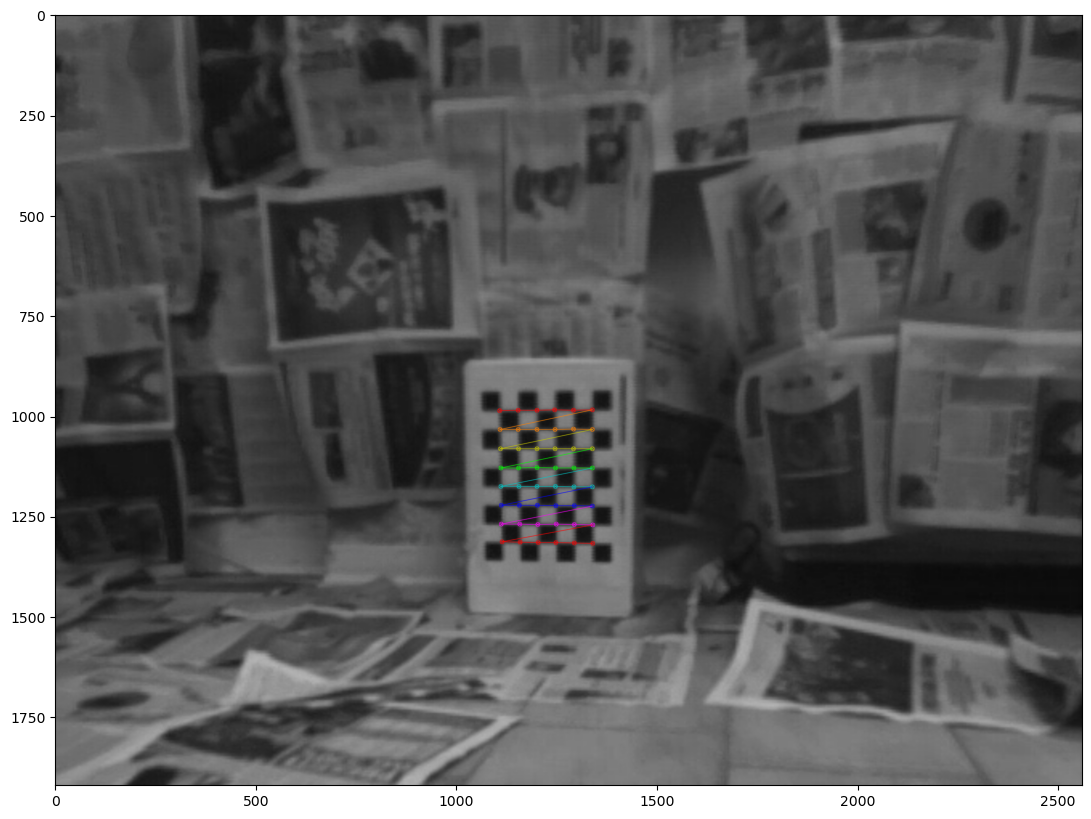

In [40]:
vis = cv2.cvtColor(imgL_gray, cv2.COLOR_GRAY2BGR)
vis = cv2.resize(vis,None,fx=4, fy=4)
cv2.drawChessboardCorners(vis, pattern_size, cornersL*4, found)
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.show()

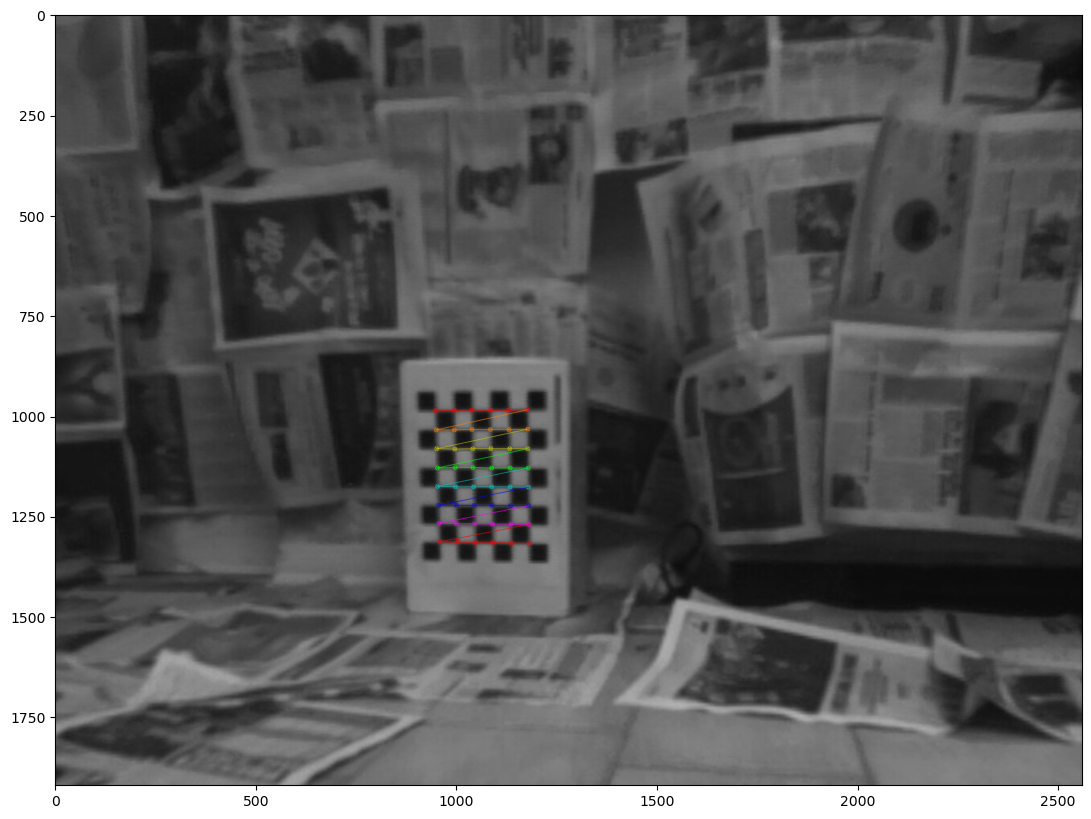

In [41]:
vis = cv2.cvtColor(imgR_gray, cv2.COLOR_GRAY2BGR)
vis = cv2.resize(vis,None,fx=4, fy=4)
cv2.drawChessboardCorners(vis, pattern_size, cornersR*4, found)
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.show()

In [42]:
Lxi = [elem[0][0] for elem in cornersL]
Rxi = [elem[0][0] for elem in cornersR]
print(Lxi) 
print(Rxi)

[276.92728, 288.51187, 300.20468, 311.33182, 322.9879, 334.66174, 277.2161, 288.53366, 300.17303, 311.5126, 323.00702, 334.67432, 277.41953, 288.64554, 300.26486, 311.60876, 323.05637, 334.69974, 277.68854, 288.85208, 300.36777, 311.8518, 323.20172, 334.7108, 277.85178, 289.04422, 300.37253, 311.86093, 323.3611, 334.77222, 278.02557, 289.1917, 300.58997, 312.06073, 323.39685, 334.7588, 278.0144, 289.5741, 300.652, 312.15082, 323.4769, 334.87503, 278.38403, 289.63144, 300.92438, 312.0662, 323.55325, 334.88135]
[236.79779, 248.71585, 259.58905, 271.24503, 282.61118, 294.19067, 237.381, 248.77657, 259.80734, 271.37018, 282.68024, 294.3914, 237.6592, 249.02568, 260.1336, 271.6233, 283.15085, 294.48, 238.15526, 249.32541, 260.3098, 271.9568, 283.47504, 294.70114, 238.30907, 249.51314, 260.63638, 272.1152, 283.53473, 294.94266, 238.93463, 249.93488, 261.28827, 272.32593, 283.81818, 295.02402, 239.15953, 250.10374, 261.49365, 272.562, 283.95096, 295.2841, 239.68327, 250.40407, 261.88556, 272.

In [43]:
diffs = []
for l, r in zip(Lxi, Rxi):
    diff = l - r
    diffs.append(diff)

d = sum(diffs)/len(diffs)

print(diffs)
print("disparity:", d)

[40.129486, 39.79602, 40.61563, 40.086792, 40.37674, 40.47107, 39.8351, 39.757095, 40.365692, 40.142426, 40.326782, 40.28293, 39.76033, 39.619858, 40.131256, 39.985474, 39.905518, 40.219727, 39.53328, 39.526672, 40.057953, 39.89502, 39.726685, 40.009644, 39.54271, 39.531082, 39.736145, 39.745728, 39.826385, 39.82956, 39.090942, 39.256836, 39.301697, 39.734802, 39.578674, 39.73477, 38.854874, 39.470352, 39.158356, 39.588806, 39.52594, 39.590942, 38.70076, 39.22737, 39.03882, 39.282623, 39.35135, 39.574768]
disparity: 39.7256555557251


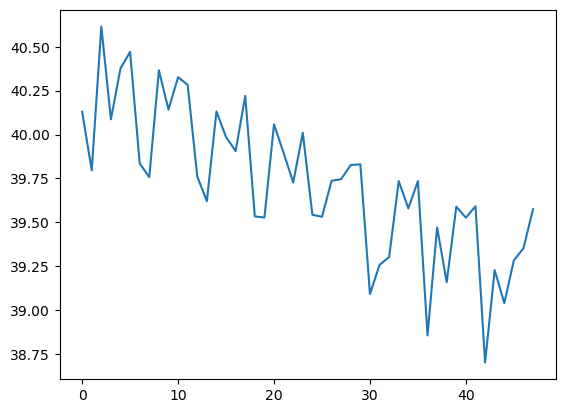

In [44]:
plt.plot(diffs)

<h2>INTERESTING</h2>

In [45]:
z = (b * f)/d 
print("Distance of the obstacle (mm):",z)

Distance of the obstacle (mm): 1316.7960721660443


# Numpy Array for frames

In [46]:
np_L = np.array(roboL_frames)
np_R = np.array(roboR_frames)
np_L_gray = np.array([cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) for frame in np_L])
np_R_gray = np.array([cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) for frame in np_R])

# computing distances of the camera from the chessboard during the whole video by uing Chessboard corner


In [112]:
pattern_size = (6, 8) # number of inner corner, (columns, rows) for OpenCV
list_foundL = []
list_cornersL = []

progress = 0
for frame in np_L_gray:
    found, corners = cv2.findChessboardCorners(frame, pattern_size)
    list_foundL.append(found)
    
    progress+=1
    if found:
        #Refining corner position to subpixel iteratively until criteria max_count=30 or criteria_eps_error=1 is sutisfied
        term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 1)
        #Image Corners 
        cv2.cornerSubPix(frame, corners, (5, 5), (-1, -1), term)
        print(progress, end=', ')
        list_cornersL.append(corners)
    else:
        print("not found", progress, end=', ')
        #list_foundL.append(None)
        list_cornersL.append(None)
    
        

print("job completed")

not found 1, 2, not found 3, 4, 5, not found 6, 7, 8, 9, not found 10, not found 11, not found 12, not found 13, 14, not found 15, 16, not found 17, not found 18, 19, not found 20, 21, not found 22, not found 23, 24, not found 25, not found 26, not found 27, not found 28, 29, not found 30, 31, not found 32, not found 33, not found 34, not found 35, not found 36, 37, 38, 39, not found 40, not found 41, not found 42, not found 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168

In [113]:
list_foundR = []
list_cornersR = []

progress = 0
for frame in np_R_gray:
    found, corners = cv2.findChessboardCorners(frame, pattern_size)
    list_foundR.append(found)
    
    progress+=1
    if found:
        #Refining corner position to subpixel iteratively until criteria max_count=30 or criteria_eps_error=1 is sutisfied
        term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 1)
        #Image Corners 
        cv2.cornerSubPix(frame, corners, (5, 5), (-1, -1), term)
        print(progress, end=', ')
        list_cornersR.append(corners)
    else:
        print("not found", progress, end=', ')
        list_cornersR.append(None)

print("job completed")

1, 2, 3, 4, 5, 6, 7, not found 8, 9, 10, not found 11, 12, not found 13, 14, not found 15, 16, not found 17, not found 18, not found 19, not found 20, not found 21, not found 22, not found 23, 24, not found 25, not found 26, not found 27, not found 28, 29, not found 30, not found 31, not found 32, not found 33, not found 34, not found 35, not found 36, 37, 38, not found 39, 40, 41, not found 42, not found 43, 44, 45, 46, 47, 48, 49, 50, 51, not found 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, not found 70, not found 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166

In [114]:
list_Lxi = []
list_Rxi = []

for frame in range(number_of_frames):
    if list_foundL[frame] and list_foundR[frame]:
        Lxi_frame = [elem[0][0] for elem in list_cornersL[frame]]
        Rxi_frame = [elem[0][0] for elem in list_cornersR[frame]]
        list_Lxi.append(Lxi_frame)
        list_Rxi.append(Rxi_frame)
    else:
        list_Lxi.append(None)
        list_Rxi.append(None)

In [115]:
print(len(list_Rxi))

389


In [116]:
list_d = []
for frame in range(number_of_frames):
    diffs = []
    if list_foundL[frame] and list_foundR[frame]:
        for l, r in zip(list_Lxi[frame], list_Rxi[frame]):
            diff = l - r
            diffs.append(diff)
        d = sum(diffs)/len(diffs)
        list_d.append(d)
    else:
        list_d.append(None)

In [117]:
list_z = []
for frame in range(number_of_frames):
    if list_foundL[frame] and list_foundR[frame]:
        z = (b * f)/list_d[frame]
        list_z.append(z)
    else:
        list_z.append(None)

In [118]:
print(list_d[100])
print(list_z[100])

39.72260030110677
1316.8973532314926


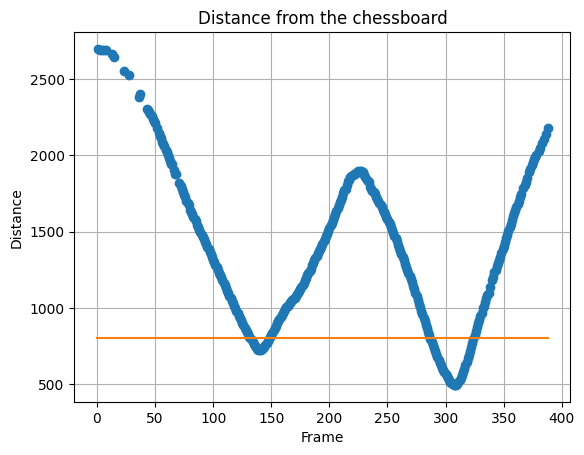

In [119]:
# Plotting
f_values = list(range(number_of_frames))
plt.plot(f_values, list_z, marker='o', linestyle='-')
line = 800*np.ones((len(f_values)))
plt.plot(f_values, line)
plt.title('Distance from the chessboard')
plt.xlabel('Frame')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

# Computing distances of the central area of the frames during the whole video by uing Disparity map


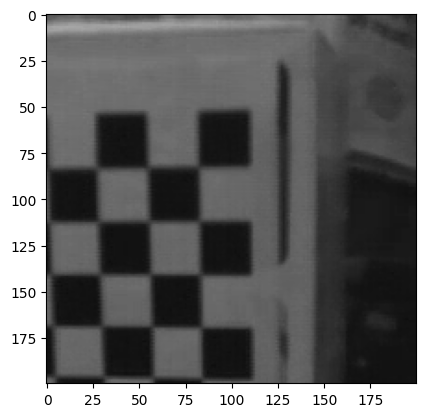

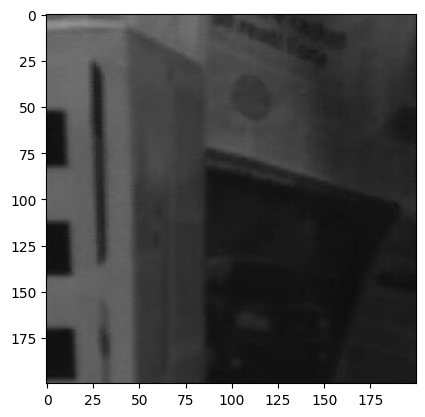

In [130]:
list_L_cropped = []
list_R_cropped = []

Box_size=200
sq_area_side=int(Box_size/2)
offset = 0

Frame_height=np_L_gray.shape[1]
Frame_width=np_L_gray.shape[2]

for framenumber in range(number_of_frames):
    np_L_cropped=np_L_gray[framenumber,int(Frame_height/2)-sq_area_side:int(Frame_height/2)+sq_area_side,int(Frame_width/2)-sq_area_side:int(Frame_width/2)+sq_area_side]
    np_R_cropped=np_R_gray[framenumber,int(Frame_height/2)-sq_area_side:int(Frame_height/2)+sq_area_side,int(Frame_width/2)-sq_area_side-offset:int(Frame_width/2)+sq_area_side-offset]
    list_L_cropped.append(np_L_cropped)
    list_R_cropped.append(np_R_cropped)

plt.imshow(cv2.cvtColor(list_L_cropped[300], cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(list_R_cropped[300], cv2.COLOR_BGR2RGB))
plt.show()

In [131]:
list_mean_disparity = []

numDisparities=64;
blockSize=21;

stereo = cv2.StereoBM_create(numDisparities, blockSize)

for framenumber in range(number_of_frames):
    disparity = stereo.compute(list_L_cropped[framenumber],list_R_cropped[framenumber])
    positive_disparities = disparity[disparity >= 0]
    disparity_px=(positive_disparities/16)
    
    
    mean_disparity = np.mean(disparity_px)

    
    list_mean_disparity.append(mean_disparity)
    print("d_mean:", mean_disparity,"frame:", framenumber)


#plt.imshow(disparity,'gray')
#plt.show()

d_mean: 19.971658506731945 frame: 0
d_mean: 19.98755123450766 frame: 1
d_mean: 19.998758847817538 frame: 2
d_mean: 20.007957809913332 frame: 3
d_mean: 20.02643074506724 frame: 4
d_mean: 19.993823364668064 frame: 5
d_mean: 20.01414640385927 frame: 6
d_mean: 19.967777451556078 frame: 7
d_mean: 19.9921570181428 frame: 8
d_mean: 19.98392874608764 frame: 9
d_mean: 19.982424246103044 frame: 10
d_mean: 19.981052118850464 frame: 11
d_mean: 20.03369003690037 frame: 12
d_mean: 20.074695046208884 frame: 13
d_mean: 20.150286259541986 frame: 14
d_mean: 20.22512404916629 frame: 15
d_mean: 20.310975012248896 frame: 16
d_mean: 20.35708561710874 frame: 17
d_mean: 20.439520991239295 frame: 18
d_mean: 20.521926382660688 frame: 19
d_mean: 20.617364309414153 frame: 20
d_mean: 20.669628373396254 frame: 21
d_mean: 20.702258557457213 frame: 22
d_mean: 20.773312887176235 frame: 23
d_mean: 20.904048985551025 frame: 24
d_mean: 20.944487873703476 frame: 25
d_mean: 20.960141188906228 frame: 26
d_mean: 20.934526665

In [132]:
list_z = []
for framenumber in range(number_of_frames):
        z = (b * f)/list_mean_disparity[framenumber]
        list_z.append(z)

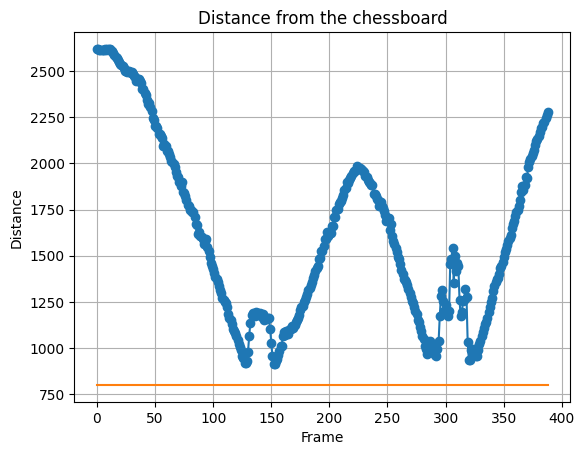

In [133]:
# Plotting
f_values = list(range(number_of_frames))
plt.plot(f_values, list_z, marker='o', linestyle='-')
line = 800*np.ones((len(f_values)))
plt.plot(f_values, line)
plt.title('Distance from the chessboard')
plt.xlabel('Frame')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

<h2> Trying to measure Chessboard W, H estimates </h2>

In [134]:
W_mm_list = []
H_mm_list = []
W_mm_diff = []
H_mm_diff = []
w_px_list = []
h_px_list = []
for frame in range(number_of_frames):
    if list_foundL[frame] and list_foundR[frame]:
        w_px = 0
        h_px = 0
        for w_line in range(8):
            w_px_R = list_cornersR[frame][6*w_line+5][0][0]-list_cornersR[frame][6*w_line+0][0][0]
            w_px_L = list_cornersL[frame][6*w_line+5][0][0]-list_cornersL[frame][6*w_line+0][0][0]
            w_px = w_px+w_px_L+w_px_R
        for h_line in range(6):
            h_px_R = list_cornersR[frame][42+h_line][0][1]-list_cornersR[frame][0+h_line][0][1]
            h_px_L = list_cornersL[frame][42+h_line][0][1]-list_cornersL[frame][0+h_line][0][1]
            h_px = h_px+h_px_L+h_px_R
       
        w_px = w_px/16
        h_px = h_px/12
        W_mm = w_px*list_z[frame]/f     
        H_mm = h_px*list_z[frame]/f   
        w_px_list.append(w_px)
        h_px_list.append(h_px) 
        W_mm_diff.append(W_mm-125)
        H_mm_diff.append(H_mm-175)
    else:
        w_px_list.append(None)
        h_px_list.append(None)
        W_mm_diff.append(None)
        H_mm_diff.append(None)
    

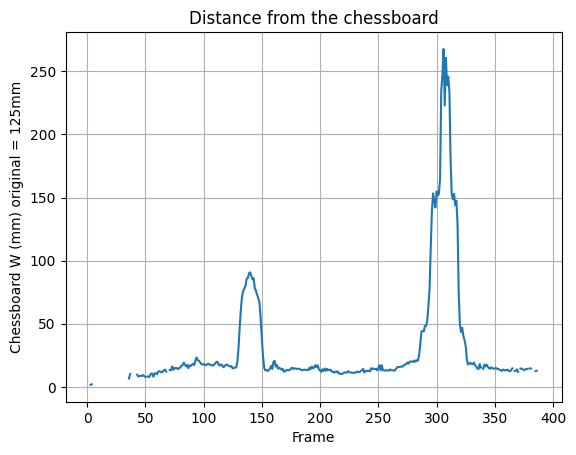

In [135]:
# Plotting
f_values = list(range(number_of_frames))
plt.plot(f_values, W_mm_diff)
plt.title('Distance from the chessboard')
plt.xlabel('Frame')
plt.ylabel('Chessboard W (mm) original = 125mm')
plt.grid(True)
plt.show()

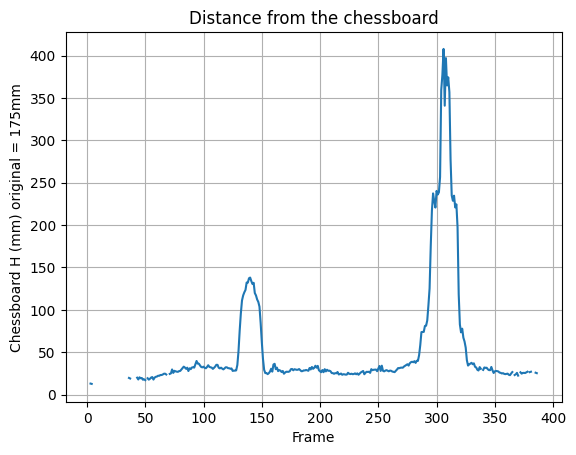

In [136]:
# Plotting
f_values = list(range(number_of_frames))
plt.plot(f_values, H_mm_diff)
plt.title('Distance from the chessboard')
plt.xlabel('Frame')
plt.ylabel('Chessboard H (mm) original = 175mm')
plt.grid(True)
plt.show()

<h2> What we can do? </h2>

We have the result already. Which is pretty okay but can be improved (maybe?)

1. Use (Moravec) corner detection to find correspondence points.
2. Use disparity ranges to calculate disparities. 
3. Vertical Slicing of image with different disparities.
4. Alarm sounding below 0.8m.

